# <center>Machine Learning and Feature Selection: Applications in Economics and Climate Change</center>
## <center>Berkay Akyapi</center>
### Figure -1

In [6]:
import sys
import os

import pycountry 
import geopandas as gpd

import rasterio

import numpy as np
from numpy import inf
import pandas as pd
import numpy.matlib
from scipy.stats import norm 
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patches as patches
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable


from matplotlib import image

import matplotlib

from matplotlib.lines import Line2D

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

from shapely.geometry import Polygon

from rasterio.plot import show

from skimage import io, color

import imageio


import ee
import geemap

# Check software versions
print('### Python version: ' + __import__('sys').version) # 3.8.8
print('### NumPy version: ' + np.__version__) # 1.20.1
print('------------')

### Python version: 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]
### NumPy version: 1.21.5
------------


# Images Features

In [7]:
## Making plots look bigger
plt.rcParams['figure.figsize'] = [18, 8]

c_white = matplotlib.colors.colorConverter.to_rgba('white',alpha = 0) # Transparent when < 35
c_red = matplotlib.colors.colorConverter.to_rgba('red') # Transparent when < 35
c_gray = matplotlib.colors.colorConverter.to_rgba('darkgray',alpha = .5)

# Patch for TMAX > 35

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color='lightgray', label= r'$T_{max}\leq 35^\circ$C'), 
           mpatches.Patch(color=matplotlib.colors.colorConverter.to_rgba('red', alpha = .55),
                          label= r'$T_{max}>$ 35$^\circ$C') ]

## Get Countries

In [8]:
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

## Get Water

In [9]:
poly1 = gpd.GeoSeries([Polygon([(-181,-90), (181,-90), (181,90), (-181,90)])]).set_crs("EPSG:4326")
df1 = gpd.GeoDataFrame({'geometry': poly1})
water = gpd.overlay(countries[countries.name!="Antarctica"],df1, how='symmetric_difference')

### Google Earth Engine account required.

In [10]:
#ee.Authenticate()
ee.Initialize()

## Get Original Images of Locations with Temperature Higher Than 35 Degrees Celsius

Panel (a)

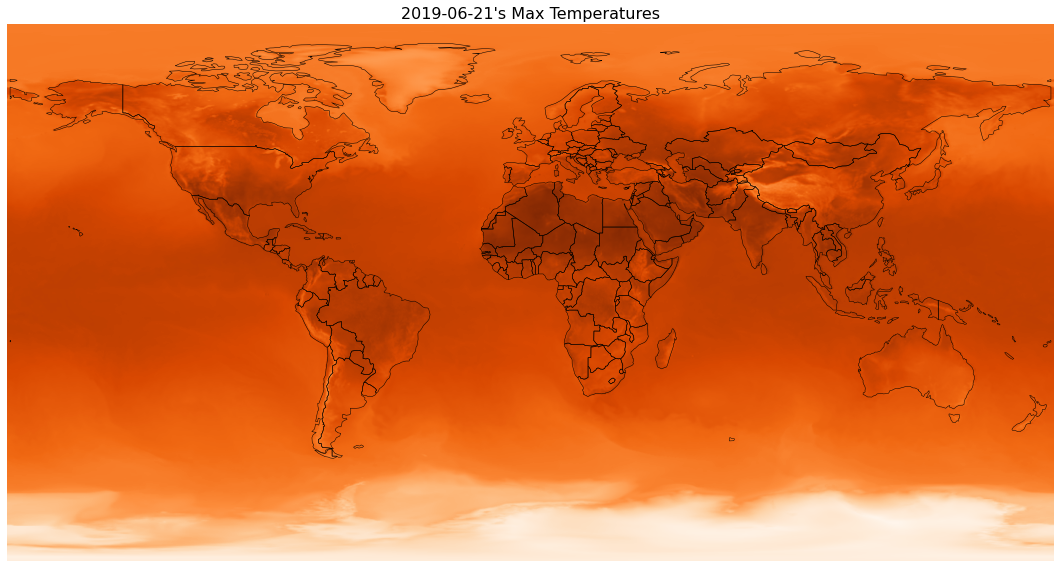

In [11]:
theCountries = ee.FeatureCollection("USDOS/LSIB/2017")

years = np.arange(2019, 2020, step = 1)

for j in years:
    
    summer_first = str(j) + '-06-21'
    summer_last = str(j) + '-06-30'

    # July First
    myTemp_summer = ee.ImageCollection('ECMWF/ERA5/DAILY').filterDate(summer_first, summer_last).select('maximum_2m_air_temperature').first()


    celsius_summer = myTemp_summer.subtract(273.13) # Convert to Celsius

    myVec = np.array([90, 60, 30, 0, -30, -60, -90], dtype=int)

    for i in range(np.shape(myVec)[0]-1):

        x1, x2, y1, y2 = -180,180,myVec[i].item(), myVec[i+1].item()

        polygon = ee.Geometry.Polygon([[x1, y2], [x2, y2], [x2, y1], [x1, y1]])

        if i == 0:

            original_summer = geemap.ee_to_numpy(celsius_summer, region=polygon)

        else:

            original_summer = np.append(original_summer, geemap.ee_to_numpy(celsius_summer, region=polygon), axis = 0)

    fig, ax = plt.subplots(1,1)

    # Original on Summer
    org1 = ax.imshow(original_summer, cmap = 'Oranges', extent=[-181,181,-90,90])
    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    #divider = make_axes_locatable(ax)
    #cax = divider.append_axes("bottom", size="5%", pad=0.05)
    #cbar = fig.colorbar(org1, cax=cax, orientation = 'horizontal')
    #cbar.ax.tick_params(labelsize=14)
    ax.set_axis_off()
    ax.set_title(summer_first + "'s Max Temperatures", fontsize = 16)

    # Add country borders
    countries[countries['name']!="Antarctica"].plot(ax = ax, color=c_white, edgecolor='black', linewidth=.5)

    plt.tight_layout()

    figName = summer_first + '_max.png'
    plt.savefig(figName, format="png", dpi=100, bbox_inches='tight')

Panel (b)

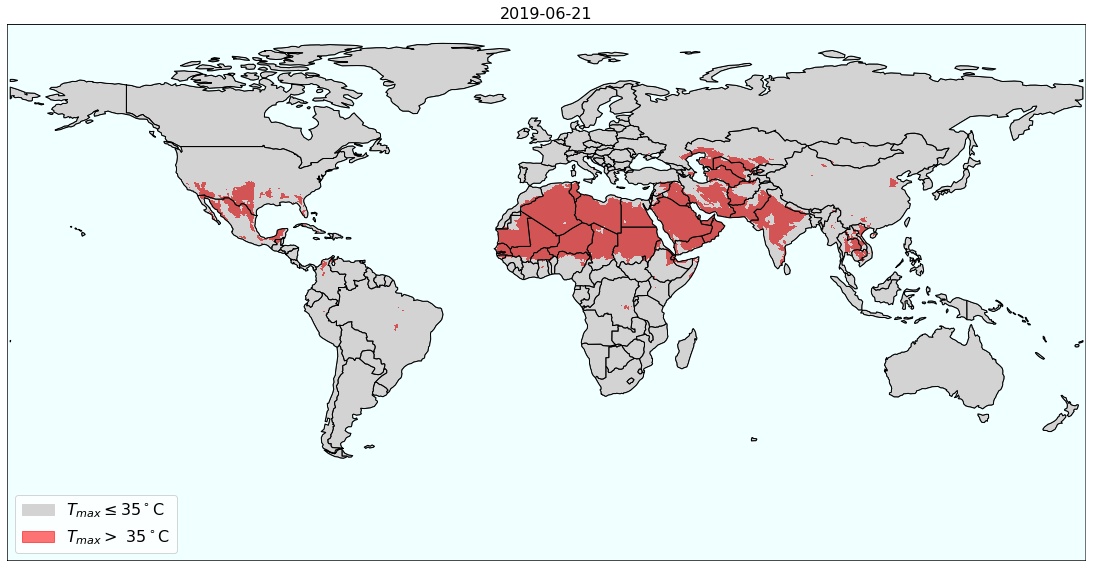

In [29]:
theCountries = ee.FeatureCollection("USDOS/LSIB/2017")

years = np.arange(2019, 2020, step = 1)

for j in years:
    
    summer_first = str(j) + '-06-21'
    summer_last = str(j) + '-09-30'

    # July First
    myTemp_summer = ee.ImageCollection('ECMWF/ERA5/DAILY').filterDate(summer_first, summer_last).select('maximum_2m_air_temperature').first()

    dif_summer = myTemp_summer.subtract(308.15) # The data is in Kelvin: 273.15 + 35 = 308.15
    myMasking_summer = dif_summer.gt(0)

    celsius_summer = myTemp_summer.subtract(273.13) # Convert to Celsius

    myVec = np.array([90, 60, 30, 0, -30, -60, -90], dtype=int)

    for i in range(np.shape(myVec)[0]-1):

        x1, x2, y1, y2 = -180,180,myVec[i].item(), myVec[i+1].item()

        polygon = ee.Geometry.Polygon([[x1, y2], [x2, y2], [x2, y1], [x1, y1]])

        if i == 0:

            masked_summer = geemap.ee_to_numpy(myMasking_summer, region=polygon)

            original_summer = geemap.ee_to_numpy(celsius_summer, region=polygon)

        else:

            masked_summer = np.append(masked_summer, geemap.ee_to_numpy(myMasking_summer, region=polygon), axis = 0)

            original_summer = np.append(original_summer, geemap.ee_to_numpy(celsius_summer, region=polygon), axis = 0)

fig, ax = plt.subplots(1,1)

# Masked on Summer
ax.imshow(masked_summer, cmap = colors.ListedColormap([c_white,c_red]), extent=[-181,181,-90,90])
ax.set_axis_off()
ax.set_title(summer_first, fontsize = 16)

# Add country borders and oceans
countries[countries['name']!="Antarctica"].plot(ax = ax, color=c_gray, edgecolor='black', linewidth=1)
water.plot(ax = ax, color='azure', edgecolor='black', linewidth=1)

# put legend-handles into the legend
ax.legend(handles=patches, loc = 'lower left', fontsize = 16)

plt.tight_layout()

figName = summer_first + '_masked.png'
plt.savefig(figName, format="png", dpi=100, bbox_inches='tight')